In [130]:
from trees import Tree
from wrappers import GPTneoX_DenseWrapper, ActivationWrapper
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch
import numpy as np
import umap
import plotly.graph_objects as go

import math
import matplotlib.pyplot as plt
import umap
from matplotlib.patches import FancyArrowPatch

## Load Model and Initialize Wrapper

In [30]:
model_name = "EleutherAI/pythia-2.8b-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
wrapper = ActivationWrapper(model_name)
layer = wrapper.make_layer_wrapper(-3, 'mlp')

## Identify All Tokens with Their IDs

In [31]:
vocab_dict = wrapper.get_vocab()
reversed_dict = {v: k for k, v in vocab_dict.items()}

token_id = 20344
print('Token ID', token_id, ':', reversed_dict[token_id])

Token ID 20344 : ĠFern


## Tree Generation Helpers

In [32]:
class TreeNode:
    def __init__(self, value, **attrs):
        self.value    = value
        self.attrs    = attrs       # all extra kwargs go here
        self.children = []

    def add_child(self, child):
        self.children.append(child)

    def __repr__(self, level=0):
        indent   = "  " * level
        attr_str = f" {self.attrs!r}" if self.attrs else ""
        ret = f"{indent}{self.value!r}{attr_str}\n"
        for c in self.children:
            ret += c.__repr__(level+1)
        return ret

def nodes_at_depth(root, target_depth):
    """
    Return a list of all nodes exactly target_depth below root.
    root is at depth 0.
    """
    if target_depth == 0:
        return [root]
    result = []
    for child in root.children:
        result.extend(nodes_at_depth(child, target_depth - 1))
    return result

def chunked(lst, n):
    """Yield successive n‐sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

def get_leaves(node):
    """
    Return a list of all leaf‐nodes in the subtree rooted at `node`.
    """
    if not node.children:
        return [node]
    leaves = []
    for child in node.children:
        leaves.extend(get_leaves(child))
    return leaves

def find_path(root, target, path=None):
    path = (path or []) + [root]
    if root is target:
        return path
    for c in root.children:
        res = find_path(c, target, path)
        if res:
            return res
    return None



## Supply a batch of inputs that root a batch of trees

In [144]:
batch = ['The']
batch_num_toks = []



In [145]:
for inp in batch:
    tokenized = tokenizer(inp, return_tensors="pt", padding=False, truncation=False)
    batch_num_toks.append(tokenized['input_ids'].shape[1])

## Top n Probs

In [152]:
# Initialize Tree
root = TreeNode("root", prob=1.0)

n = 4 #Number of Children for each node
num_gens = 4 #Depth of Tree

split_inds = [0 + i * (n**num_gens) for i in range(len(batch))]
hold_sens = batch
batch_toks = []

# Add batch inputs as children of root
for i, sen in enumerate(batch):
    child = TreeNode(str(i), string=sen, prob = 1.0)
    root.add_child(child)


for i in range(num_gens):
    print("GEN:", i)
    working_nodes = nodes_at_depth(root, i+1)
    thing, new_sens, prob = wrapper.generate_and_prepare_top_n(hold_sens, n)
    if i == num_gens - 1:
        batch_toks = thing
    chunks = list(chunked(new_sens, n))
    chunks2 = list(chunked(prob, n))

    for j, node in enumerate(working_nodes):
        for k, val in enumerate(chunks[j]):
            name = str(node.value) + '.' + str(j)
            child = TreeNode(name, string = val , prob= chunks2[j][k])
            node.add_child(child)

    #res, to = layer.batch_activations(thing, tokens='last', tokenized_prior=True)
    #acts.append(res.detach().numpy())

    hold_sens = new_sens

print(root)

GEN: 0
GEN: 1
GEN: 2
GEN: 3
'root' {'prob': 1.0}
  '0' {'string': 'The', 'prob': 1.0}
    '0.0' {'string': 'The first', 'prob': 0.3442060053348541}
      '0.0.0' {'string': 'The first thing', 'prob': 0.3659687042236328}
        '0.0.0.0' {'string': 'The first thing I', 'prob': 0.33737170696258545}
          '0.0.0.0.0' {'string': 'The first thing I noticed', 'prob': 0.34534820914268494}
          '0.0.0.0.0' {'string': 'The first thing I did', 'prob': 0.320783793926239}
          '0.0.0.0.0' {'string': 'The first thing I do', 'prob': 0.18169403076171875}
          '0.0.0.0.0' {'string': 'The first thing I want', 'prob': 0.1521739959716797}
        '0.0.0.0' {'string': 'The first thing you', 'prob': 0.2704247832298279}
          '0.0.0.0.1' {'string': 'The first thing you need', 'prob': 0.49143877625465393}
          '0.0.0.0.1' {'string': 'The first thing you should', 'prob': 0.26342329382896423}
          '0.0.0.0.1' {'string': "The first thing you'll", 'prob': 0.13697874546051025}
  

## Probabilities at Base of Tree

In [153]:
tree_top = get_leaves(root) #Obtain all sequences at maximum tree depth

tree_top_sens = []
cumulative_probs = {}

for sen in batch:
    cumulative_probs[sen] = []

for node in tree_top:
    phrase = node.attrs['string']
    tree_top_sens.append(phrase)
    path = find_path(root, node)
    path_base = path[1].attrs['string']
    print('\n')
    print('SEQUENCE:', phrase)
    prob = 1.0 
    for node2 in path:
        temp = node2.attrs.get("prob")
        prob = prob * temp
    print('CUMULATIVE PROBABILITY:', prob)
    temp = cumulative_probs[path_base]
    temp.append(prob)
    cumulative_probs[path_base] = temp



SEQUENCE: The first thing I noticed
CUMULATIVE PROBABILITY: 0.01467669463136556


SEQUENCE: The first thing I did
CUMULATIVE PROBABILITY: 0.013632749965126126


SEQUENCE: The first thing I do
CUMULATIVE PROBABILITY: 0.007721678396571384


SEQUENCE: The first thing I want
CUMULATIVE PROBABILITY: 0.00646712856932243


SEQUENCE: The first thing you need
CUMULATIVE PROBABILITY: 0.016740880742331904


SEQUENCE: The first thing you should
CUMULATIVE PROBABILITY: 0.008973524597208021


SEQUENCE: The first thing you'll
CUMULATIVE PROBABILITY: 0.004666186212380558


SEQUENCE: The first thing you do
CUMULATIVE PROBABILITY: 0.0036844480315728523


SEQUENCE: The first thing that I
CUMULATIVE PROBABILITY: 0.008264712021315148


SEQUENCE: The first thing that struck
CUMULATIVE PROBABILITY: 0.006260804815401537


SEQUENCE: The first thing that comes
CUMULATIVE PROBABILITY: 0.005881947511289753


SEQUENCE: The first thing that you
CUMULATIVE PROBABILITY: 0.005638200446790107


SEQUENCE: The first th

## Activations at Base of Tree

In [154]:
print(len(tree_top_sens))

256


In [155]:
act, toks = layer.batch_activations(batch_toks, tokens='all', tokenized_prior=True)


In [161]:
act_per_input = [act[split_inds[i]:split_inds[i+1]] for i in range(len(split_inds)-1)] + [act[split_inds[-1]:]]

print(act_per_input[0].shape)

torch.Size([256, 5, 2560])


(1280, 2560)


/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


(1280, 2)
[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 81

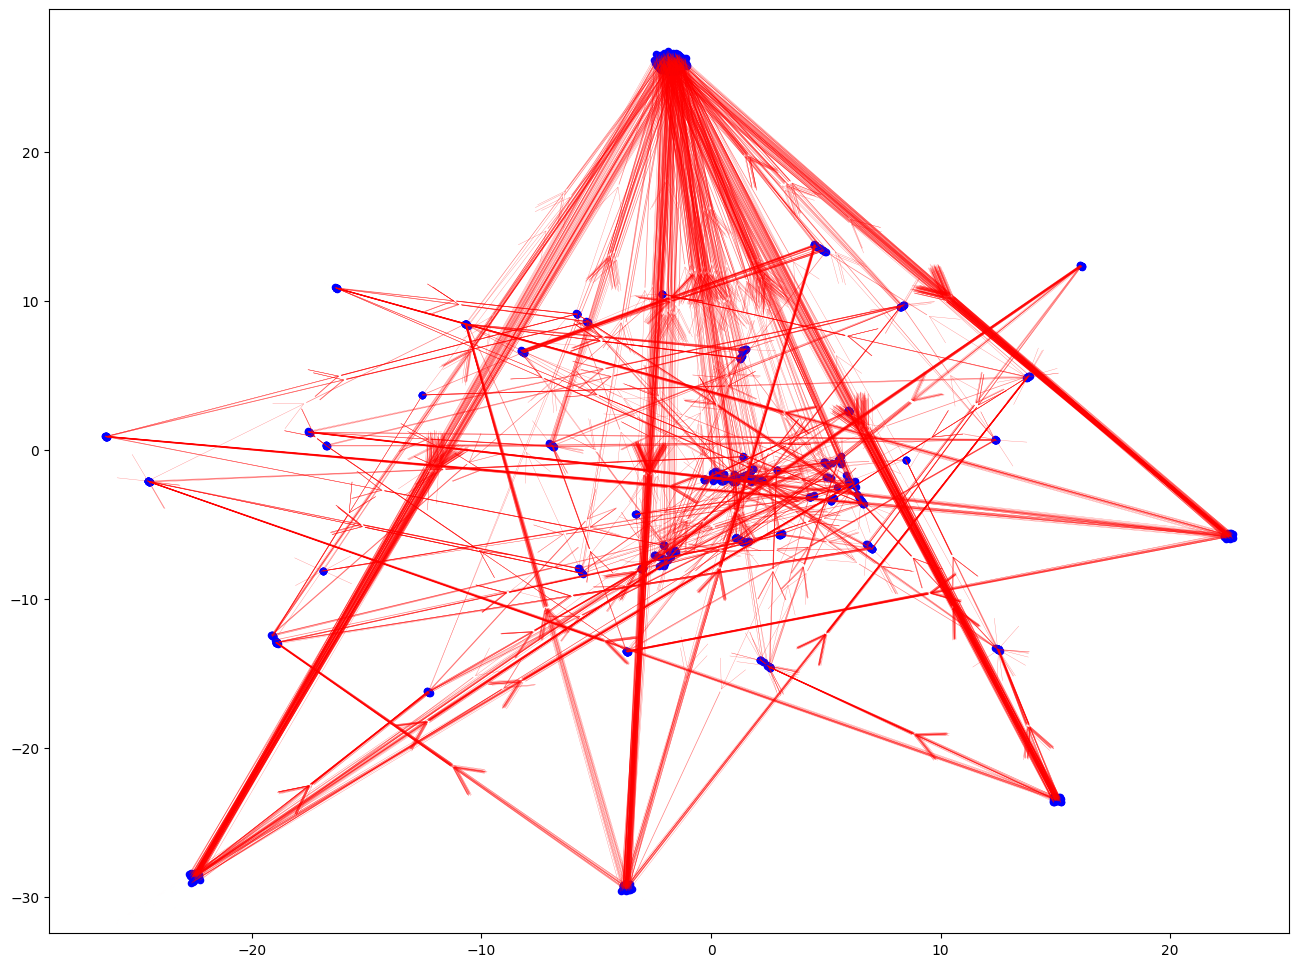

In [157]:
act_per_input = [act[split_inds[i]:split_inds[i+1]] for i in range(len(split_inds)-1)] + [act[split_inds[-1]:]]

all_acts = []

for i, a in enumerate(act_per_input):
    for j, b in enumerate(a):
        #print(b.shape)
        all_acts.append(b)


acts = torch.cat(all_acts, dim=0).detach().numpy()

print(acts.shape)

umap_model = umap.UMAP(n_components=2) 
X_umap = umap_model.fit_transform(acts)
print(X_umap.shape)
split_inds2 = [0 + i * (num_gens) for i in range(int(X_umap.shape[0]/toks[0].item()))]
print(split_inds2)

plt.figure(figsize=(16, 12))
plt.scatter(X_umap[:, 0], X_umap[:, 1], color='blue', s=20)

# Add directional arrows connecting consecutive points
for i in range(1, len(X_umap)):
    if i in split_inds:
        continue  # Skip adding arrows for the break indices
    start_point = X_umap[i - 1]
    end_point = X_umap[i]
    midpoint = (start_point + end_point) / 2
    plt.plot([midpoint[0], end_point[0]], [midpoint[1], end_point[1]], color='red', linewidth=0.5, alpha=0.5)
    arrow = FancyArrowPatch(start_point, midpoint, mutation_scale=50, color='red', arrowstyle='->', linewidth=0.25, alpha=0.5)
    plt.gca().add_patch(arrow)

## Probability of Sequence Generation Up to Probability of First Token

Samples from all token probabilities at each generation step, not just from the top n most likely tokens. 

In [24]:
cumulative_probs_all = []

for i, sen in enumerate(tree_top_sens):
    p, ids = wrapper.prob_of_generation(sen, 0.5)
    print('SEQUENCE:', sen)

    num_sens, seq_len, _ = p.shape

    gen_probs = np.zeros((num_sens, seq_len-1))

    for i in range(num_sens):
        for j in range(seq_len-1):
            gen_probs[i,j] = p[i,j, ids[i, j+1]]

    trun_probs = gen_probs[0, -num_gens:]
    mult_prob = np.prod(trun_probs)
    print(trun_probs.shape)
    cumulative_probs_all.append(mult_prob)

    print('PROBABILITIES OF GENERATION', mult_prob)
    print(cumulative_probs[i] / mult_prob)
    print('\n')


SEQUENCE: Pigeons are a common sight in the city, and
(8,)
PROBABILITIES OF GENERATION 0.011208758007423984


KeyError: 0

## Entropy From Top n Generation



In [28]:
def entropy(p, base=2):
    """Compute Shannon entropy of distribution p (list of floats summing to 1)."""
    log_fn = math.log if base == math.e else (lambda x: math.log(x, base))
    H = 0.0
    for pi in p:
        if pi > 0:
            H -= pi * log_fn(pi)
    return H

total_entropies = []

for key, val in cumulative_probs.items():
    total_entropies.append(entropy(val))

print(total_entropies)

[5.529653915861313, 6.357395526704462]


## Entropy vs. Tree Depth

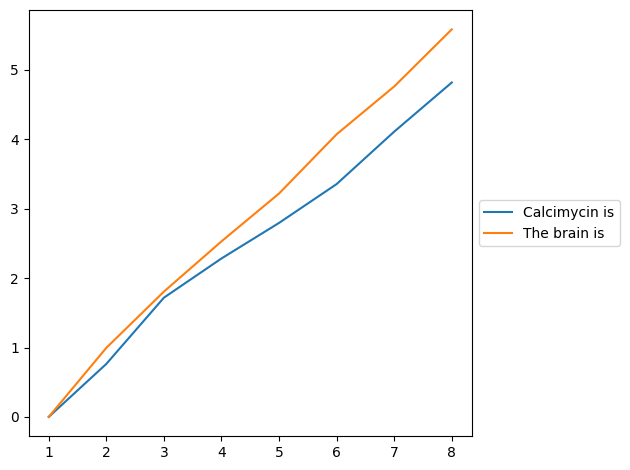

In [29]:
max_depth = num_gens + 1
entropy_vals = []

depth_probs = {}
for sen in batch:
    depth_probs[sen] = {}
    for j in range(1,max_depth):
        depth_probs[sen][j] = []

for i in range(1,max_depth):

    nodes = nodes_at_depth(root, i)
    for node in nodes:
        path = find_path(root, node)
        path_base = path[1].attrs['string']
        prob = 1.0 
        for node2 in path:
            temp = node2.attrs.get("prob")
            prob = prob * temp
        temp = depth_probs[path_base][i]
        temp.append(prob)
        depth_probs[path_base][i] = temp
    
entropies = {}
for key, d in depth_probs.items():
    temp = []
    for depth, probs in d.items():
        temp.append(entropy(probs))
    entropies[key] = temp

fig, ax = plt.subplots()
for key, val in entropies.items():
    ax.plot(range(1, max_depth), val, label=key)

# put legend to the right, centered vertically
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# make room on the right for the legend
plt.tight_layout()
plt.show()
        

# Sequential Generation Cell

In [ ]:
num_tok_samples = 1
temp = 0.5

all_to_embed = []
colors = []

num_gens = 10

hold_sens = names

acts = []

for i in range(num_gens):
    thing, new_sens, prob = wrapper.generate_and_prepare(hold_sens, num_tok_samples, temp)
    print(prob)
    res, to = layer.batch_activations(thing, tokens='last', tokenized_prior=True)
    all_to_embed.append(new_sens)
    blue = [i] * len(new_sens)
    colors.append(blue)
    hold_sens = new_sens
    acts.append(res.detach().numpy())

In [ ]:
ind = 1

acts_in_use = acts[ind]
sens_in_use = all_to_embed[ind]

In [ ]:
umapper = umap.UMAP(n_components=3)
emb = umapper.fit_transform(acts_in_use)
print(emb.shape)

x, y, z = emb[:, 0], emb[:, 1], emb[:, 2]
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.8
    ),
    text=sens_in_use,
    hoverinfo='text'        
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)